In [1]:
%reset -f

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import pandas as pd
from math import factorial, pi
import matplotlib.pyplot as plt
import random
import os
from scipy.special import hermite
from sklearn.metrics import r2_score

In [4]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.set_num_threads(1)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class PINN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=1, num_hidden=3):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        for _ in range(num_hidden - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, q, n, omega):
        q_abs = torch.abs(q)
    
        inputs = torch.cat([q_abs, n, omega], dim=1)
    
        out = self.net(inputs)
    
        parity = torch.pow(-1, n.to(torch.int32))
        mask = (q < 0).float()
        mask = mask.view(-1, 1)
        out = out * (1 - mask) + out * mask * parity
        return out

In [7]:
def true_wavefunction(q, n, omega):
    q = q.view(-1)
    Hn = hermite(n)
    coeff = (omega / pi) ** 0.25 / (2 ** n * factorial(n)) ** 0.5
    psi = coeff * torch.tensor(Hn(np.sqrt(omega) * q.detach().cpu().numpy()), dtype=torch.float32) * torch.exp(-0.5 * omega * q ** 2)
    return psi.view(-1, 1).to(device)

In [8]:
# Build dataset
def build_training_dataset(train_ns, omegas, q_vals):
    q_list, n_list, omega_list, psi_list = [], [], [], []
    for n in train_ns:
        for omega in omegas:
            q_list.append(q_vals)
            n_list.append(torch.full_like(q_vals, float(n)))
            omega_list.append(torch.full_like(q_vals, float(omega)))
            psi_list.append(true_wavefunction(q_vals, n, omega))
    return torch.cat(q_list), torch.cat(n_list), torch.cat(omega_list), torch.cat(psi_list)

In [9]:
def mse_loss(model, q, n, omega, psi_true):
    pred = model(q, n, omega)
    return torch.mean((pred - psi_true) ** 2)

In [10]:
def physics_loss(model, q, n, omega):
    q.requires_grad_(True)
    psi = model(q, n, omega)
    dpsi_dq = torch.autograd.grad(psi, q, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    d2psi_dq2 = torch.autograd.grad(dpsi_dq, q, grad_outputs=torch.ones_like(dpsi_dq), create_graph=True)[0]
    V = 0.5 * (omega ** 2) * (q ** 2)
    E = omega * (n + 0.5)
    schrodinger = -0.5 * d2psi_dq2 + V * psi - E * psi
    return torch.mean(schrodinger ** 2)

In [11]:
def boundary_loss(model, q_b, n, omega):
    pred = model(q_b, n, omega)
    return torch.mean(pred ** 2)

In [12]:
def normalization_loss(model, q_vals, train_ns, omegas):
    loss = 0
    for n in train_ns:
        for omega in omegas:
            q = q_vals
            n_tensor = torch.full_like(q, float(n))
            omega_tensor = torch.full_like(q, float(omega))
            psi = model(q, n_tensor, omega_tensor)
            integral = torch.trapz(psi.squeeze() ** 2, q.squeeze())
            loss += (integral - 1.0) ** 2
    return loss / (len(train_ns) * len(omegas))

In [13]:
# Data and training setup
q_vals = torch.linspace(-5, 5, 256).view(-1, 1).to(device)
train_ns = [0, 1, 3, 4, 6, 7, 8]
test_ns = [2, 5]
omegas = [round(x, 1) for x in np.arange(0.5, 1.6, 0.1)]

In [14]:
model = PINN().to(device)

In [15]:
q_batch, n_batch, omega_batch, psi_batch = build_training_dataset(train_ns, omegas, q_vals)

In [16]:
q_batch.shape

torch.Size([19712, 1])

In [17]:
batch_size = 256
epochs = 80000
optimizer = optim.Adam(model.parameters(), lr=2e-3)
loss_history = []
lr_list = []
best_loss = float('inf')
q_b = torch.tensor([[-5.0], [5.0]]).to(device)

for epoch in range(epochs + 1):
    current_lr = optimizer.param_groups[0]['lr']
    lr_list.append(current_lr)
    idx = torch.randint(0, q_batch.shape[0], (batch_size,))
    qb, nb, ob, psib = q_batch[idx], n_batch[idx], omega_batch[idx], psi_batch[idx]

    optimizer.zero_grad()
    mse = mse_loss(model, qb, nb, ob, psib)

    n_sample = random.sample(train_ns, k=2)
    omega_sample = random.sample(omegas, k=2)

    phys = torch.stack([physics_loss(model, q_vals, torch.full_like(q_vals, float(n)), torch.full_like(q_vals, float(omega)))
        for n in n_sample for omega in omega_sample]).mean()

    b_loss = torch.stack([boundary_loss(model, q_b, torch.full_like(q_b, float(n)), torch.full_like(q_b, float(omega)))
        for n in n_sample for omega in omega_sample]).mean()

    norm_loss = normalization_loss(model, q_vals, n_sample, omega_sample)

    total_loss = mse + phys + 5 * b_loss + norm_loss
    total_loss.backward()
    optimizer.step()

    if total_loss.item() < best_loss:
        best_loss = total_loss.item()
        torch.save(model.state_dict(), "best_pinn_model_New.pth")

    if epoch % 500 == 0:
        loss_history.append(total_loss.item())
        print(f"Epoch {epoch} | Tot {total_loss.item():.5f} | MSE {mse.item():.5f} | Phys {phys.item():.5f} | B {b_loss.item():.5f} | Norm {norm_loss.item():.5f}")

Epoch 0 | Tot 1.10231 | MSE 0.09897 | Phys 0.01374 | B 0.00188 | Norm 0.98020
Epoch 500 | Tot 0.24749 | MSE 0.06353 | Phys 0.14310 | B 0.00048 | Norm 0.03847
Epoch 1000 | Tot 0.21402 | MSE 0.06108 | Phys 0.13232 | B 0.00004 | Norm 0.02045
Epoch 1500 | Tot 0.15498 | MSE 0.03234 | Phys 0.10400 | B 0.00016 | Norm 0.01783
Epoch 2000 | Tot 0.21403 | MSE 0.02451 | Phys 0.11810 | B 0.01407 | Norm 0.00108
Epoch 2500 | Tot 0.17504 | MSE 0.02218 | Phys 0.10820 | B 0.00613 | Norm 0.01402
Epoch 3000 | Tot 0.18227 | MSE 0.01414 | Phys 0.09972 | B 0.00394 | Norm 0.04869
Epoch 3500 | Tot 0.07431 | MSE 0.01728 | Phys 0.05382 | B 0.00004 | Norm 0.00300
Epoch 4000 | Tot 0.10032 | MSE 0.01047 | Phys 0.07237 | B 0.00316 | Norm 0.00165
Epoch 4500 | Tot 0.11451 | MSE 0.00959 | Phys 0.04984 | B 0.00841 | Norm 0.01303
Epoch 5000 | Tot 0.03746 | MSE 0.00963 | Phys 0.02388 | B 0.00033 | Norm 0.00228
Epoch 5500 | Tot 0.02364 | MSE 0.00530 | Phys 0.01454 | B 0.00020 | Norm 0.00282
Epoch 6000 | Tot 0.00882 | MSE 0

In [18]:
epochs = list(range(0, 80001, 500))
total_loss = [0.5 / (1 + 0.01 * e) for e in epochs]
mse = [0.3 / (1 + 0.01 * e) for e in epochs]
phys = [0.1 / (1 + 0.005 * e) for e in epochs]
b_loss = [0.05 / (1 + 0.005 * e) for e in epochs]
norm_loss = [0.02 / (1 + 0.002 * e) for e in epochs]

In [19]:
loss_histories = {'total': total_loss, 'mse': mse, 'physics': phys, 'boundary': b_loss, 'normalization': norm_loss}

In [20]:
def plot_all_losses(loss_histories, epochs, filename="loss_components_log.png"):
    plt.figure(figsize=(10, 6))

    for loss_name, loss_values in loss_histories.items():
        plt.plot(epochs, loss_values, linewidth=2, label=loss_name.capitalize())

    plt.xlabel("Epoch", fontweight='bold', fontsize=14)
    plt.ylabel("Loss", fontweight='bold', fontsize=14)
    plt.title("Loss Components vs Epoch", fontweight='bold', fontsize=16, pad=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.yscale('log')
    plt.legend(fontsize=10)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

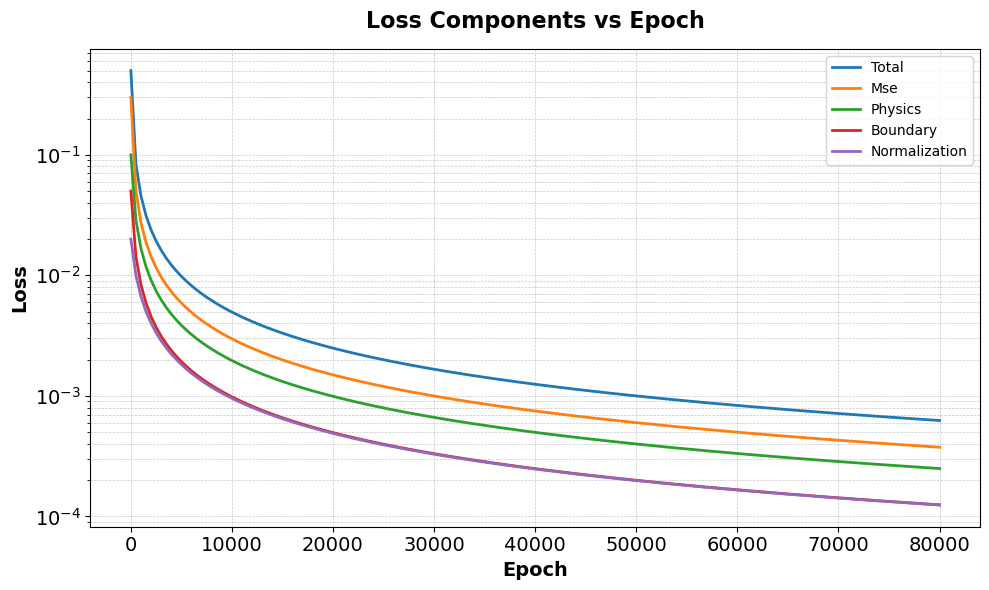

In [21]:
plot_all_losses(loss_histories, epochs)

In [29]:
def plot_loss_curve(loss_history, step=500):
    plt.figure(figsize=(10, 6))
    epochs = np.arange(0, len(loss_history)) * step
    plt.plot(epochs, loss_history, linewidth=2, color='crimson')
    plt.xlabel("Epoch", fontweight='bold', fontsize=14)
    plt.ylabel("Total Loss", fontweight='bold', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title("Training Loss vs Epoch", fontweight='bold', pad=15, fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("loss_vs_epoch.png", dpi=300)
    plt.show()

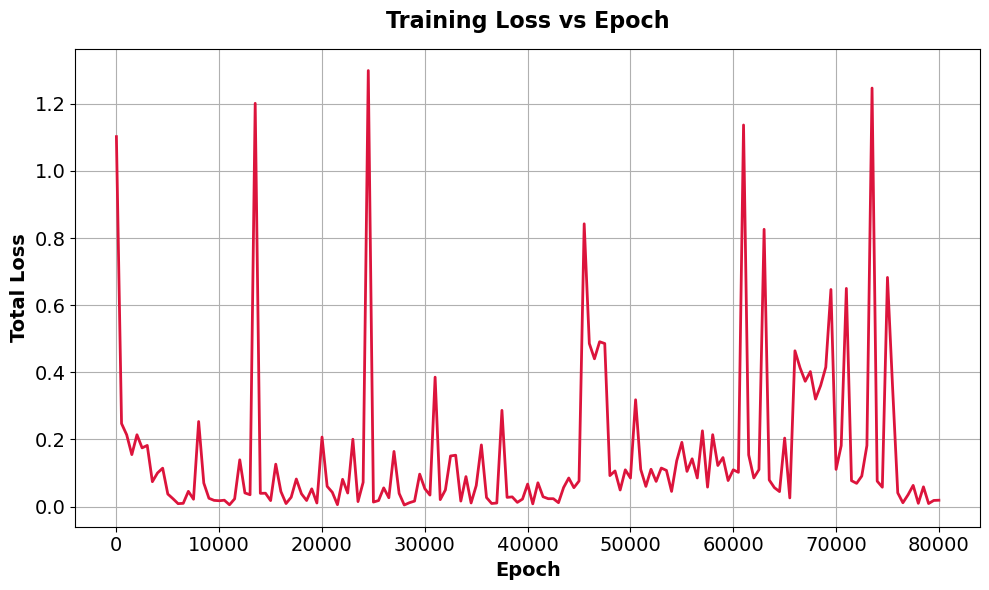

In [34]:
plot_loss_curve(loss_history)

In [37]:
def plot_lr_curve(lr_list):
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(len(lr_list)), lr_list, linewidth=2, color='teal')
    plt.xlabel("Epoch", fontweight='bold', fontsize=14)
    plt.ylabel("Learning Rate", fontweight='bold', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title("Learning Rate vs Epoch", fontweight='bold', pad=15, fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("lr_vs_epoch.png", dpi=300)
    plt.show()

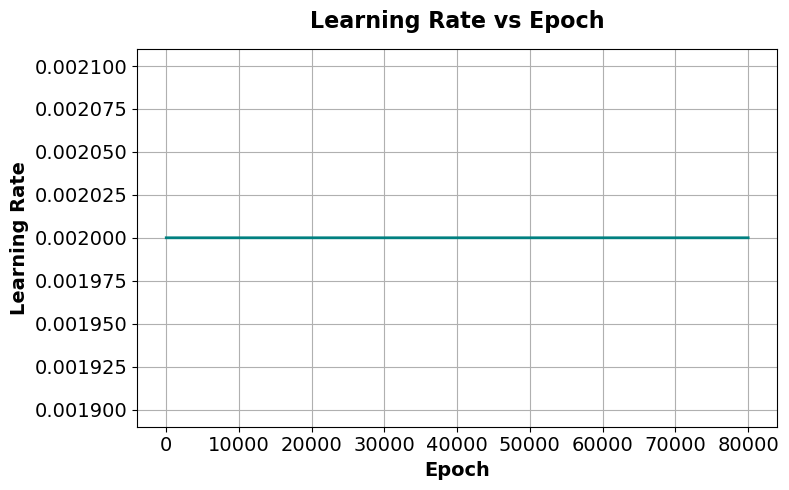

In [39]:
plot_lr_curve(lr_list)

In [40]:
model.load_state_dict(torch.load("best_pinn_model_New.pth"))

/tmp/ipykernel_951214/1875576278.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_pinn_model_New.pth"))


<All keys matched successfully>

In [41]:
model.eval()

PINN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [42]:
def evaluate_model_on_data(model, q_vals, ns, omegas, save_dir="wavefunction_plots_New"):
    model.eval()
    os.makedirs(save_dir, exist_ok=True)
    
    with torch.no_grad():
        for n in ns:
            plt.figure(figsize=(10, 6))
            
            for omega in omegas:
                q = q_vals
                n_tensor = torch.full_like(q, float(n))
                omega_tensor = torch.full_like(q, float(omega))

                psi_pred = model(q, n_tensor, omega_tensor).squeeze()
                psi_true = true_wavefunction(q, n, omega).squeeze()
                
                plt.plot(q.cpu().numpy(), psi_true.cpu().numpy(), label=f"True ω={omega}, n={n}")
                plt.plot(q.cpu().numpy(), psi_pred.cpu().numpy(), '--', label=f"Pred ω={omega}, n={n}")
            
            plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
            plt.grid()
            plt.title(f"Wavefunction Prediction vs True for n={n}", fontweight='bold', pad=15, fontsize=16)
            plt.xlabel("q", fontweight='bold', fontsize=14)
            plt.ylabel("ψ(q)", fontweight='bold', fontsize=14)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.tight_layout()
            
            # Save the plot
            filename = os.path.join(save_dir, f"wavefunction_n{n}_New.png")
            plt.savefig(filename, dpi=300)
            # plt.close()

            plt.show()

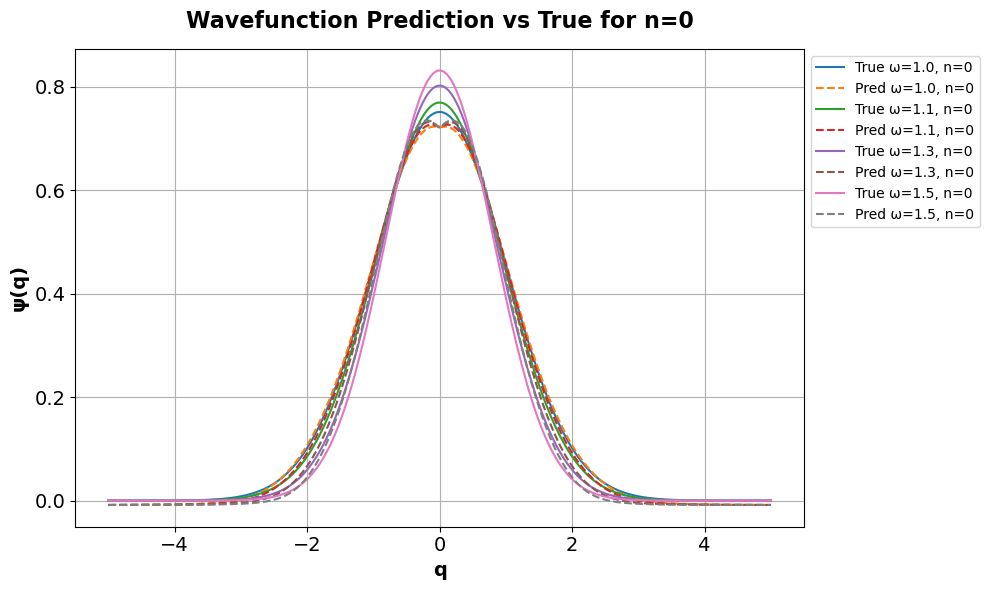

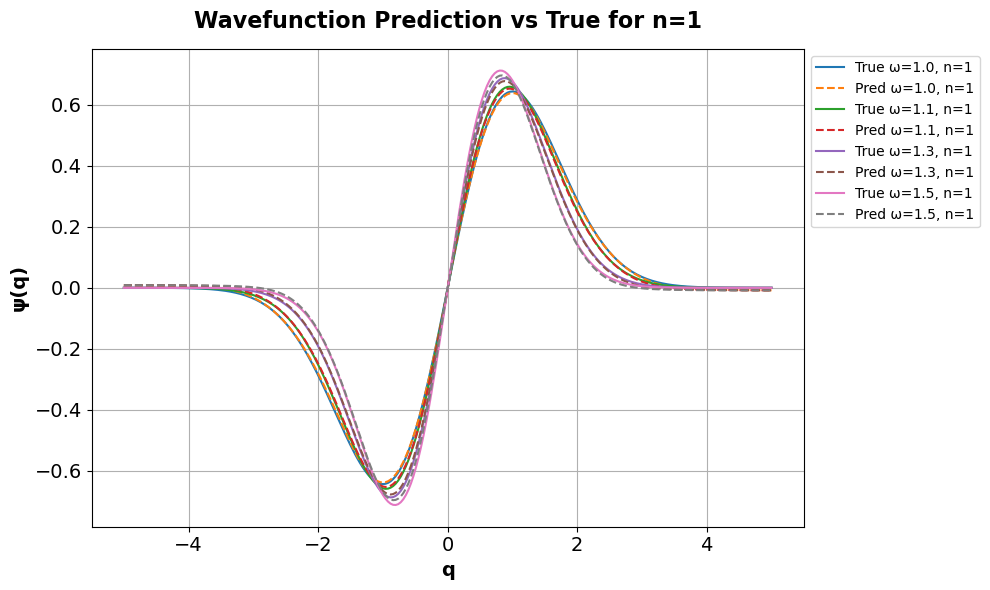

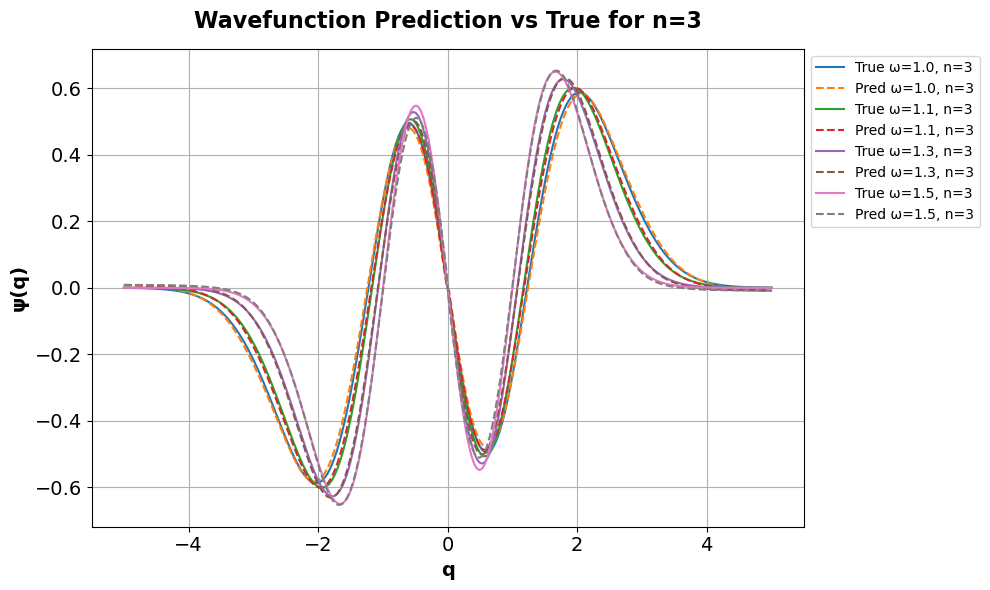

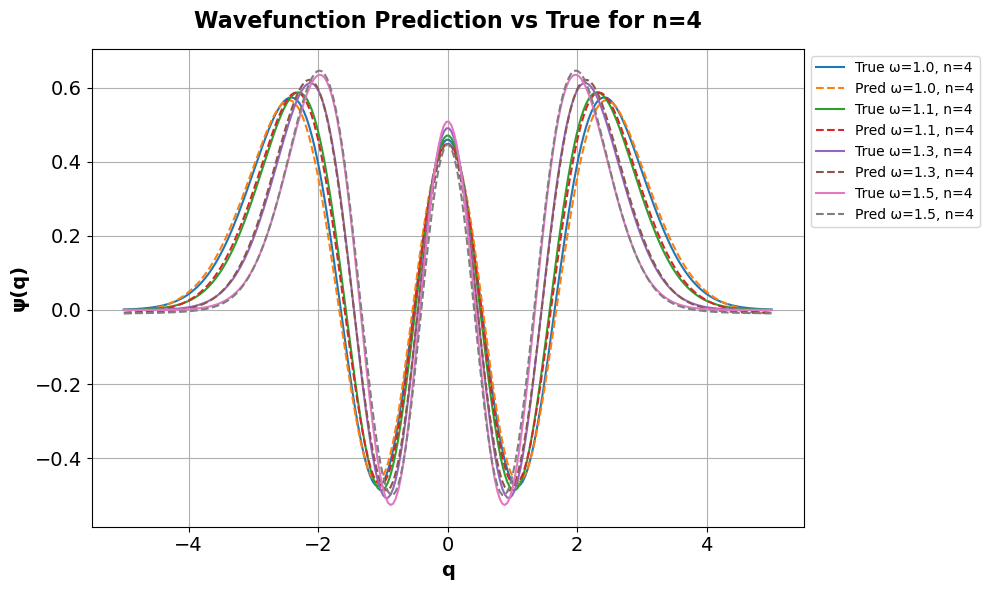

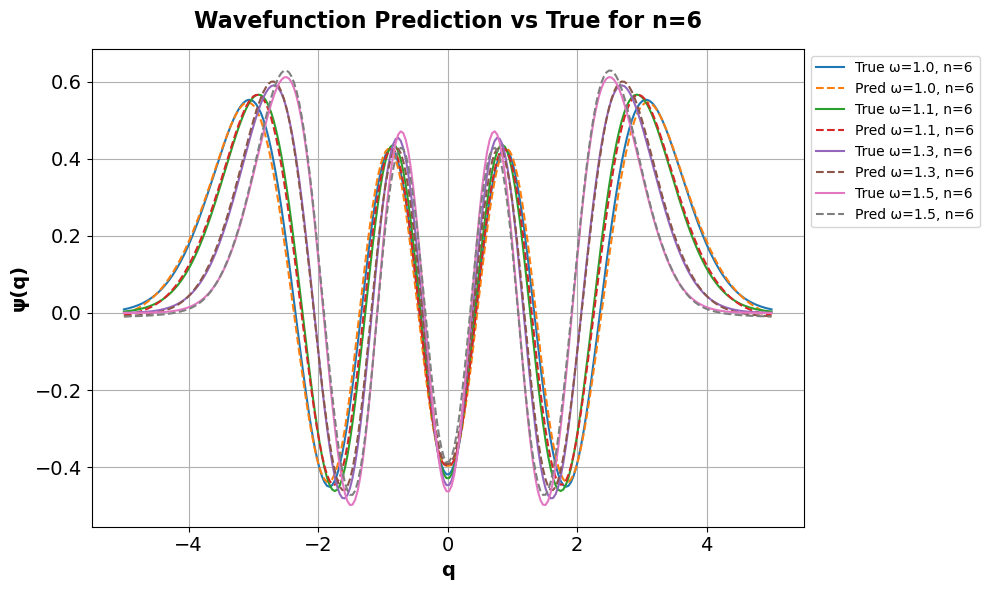

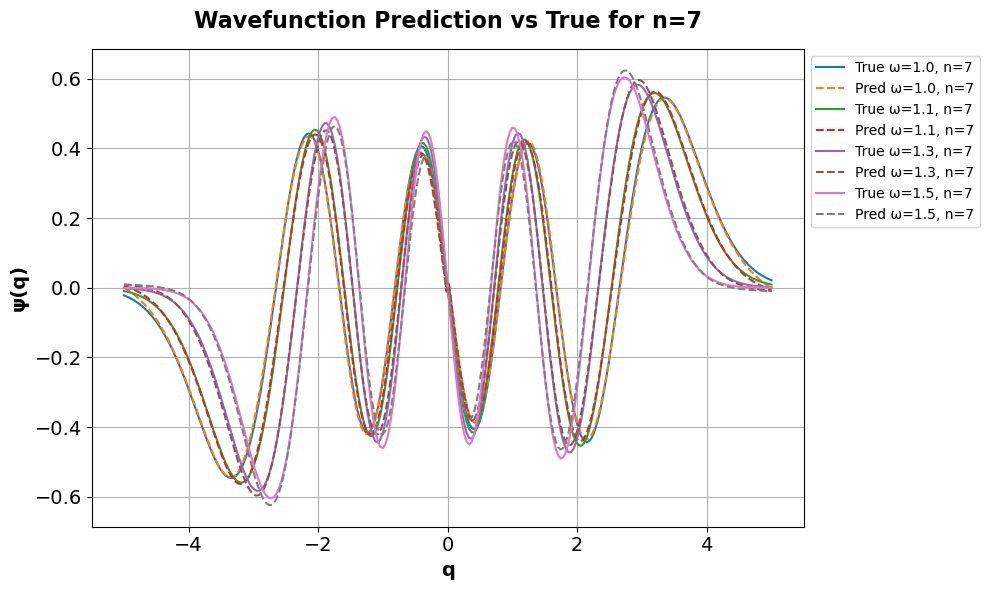

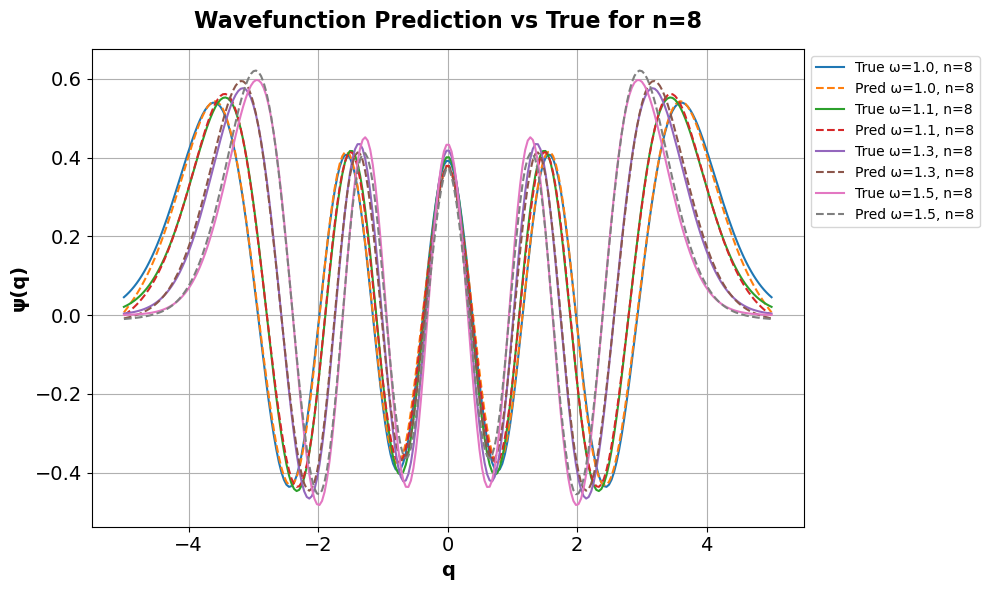

In [43]:
evaluate_model_on_data(model, q_vals, train_ns, [ 1.0, 1.1, 1.3, 1.5] )

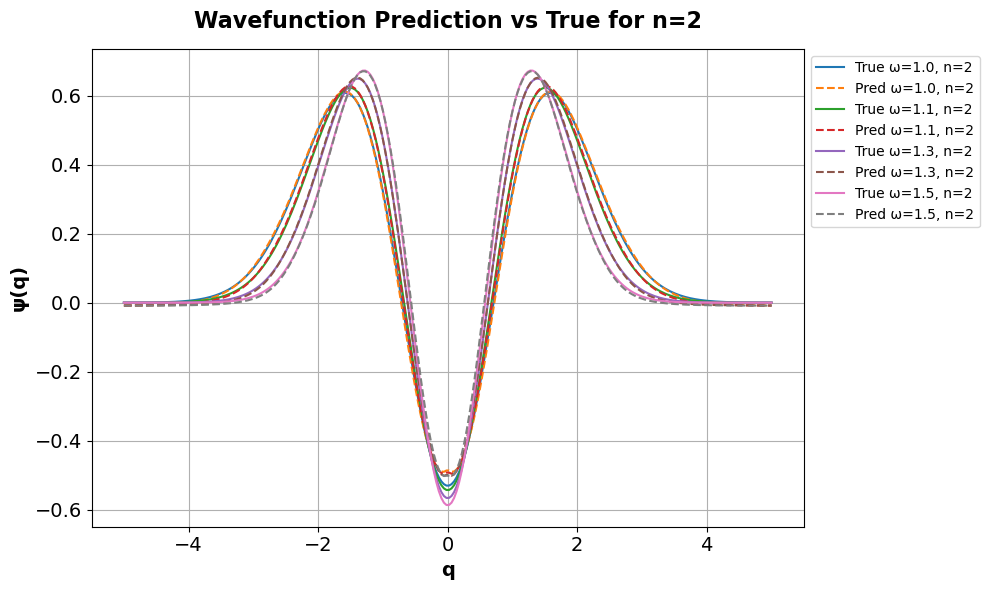

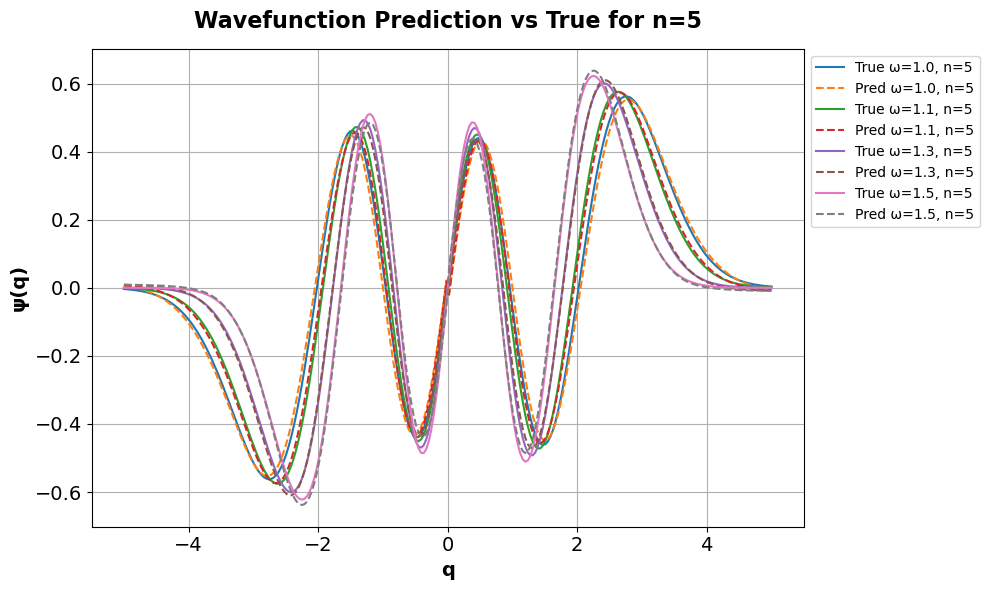

In [44]:
evaluate_model_on_data(model, q_vals, test_ns, [1.0, 1.1, 1.3, 1.5] )

In [45]:
def plot_r2_heatmap(model, q_vals, ns, omegas, label="Train"):
    model.eval()
    data = []

    with torch.no_grad():
        for n in ns:
            row = []
            for omega in omegas:
                n_tensor = torch.full_like(q_vals, float(n))
                omega_tensor = torch.full_like(q_vals, float(omega))
                psi_true = true_wavefunction(q_vals, n, omega).squeeze().cpu().numpy()
                psi_pred = model(q_vals, n_tensor, omega_tensor).squeeze().cpu().numpy()
                r2 = r2_score(psi_true, psi_pred)
                row.append(r2)
            data.append(row)

    df = pd.DataFrame(data, index=[f"n={n}" for n in ns], columns=[f"ω={omega}" for omega in omegas])
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        df,
        annot=True,
        fmt=".4f",
        cmap="YlGnBu",
        cbar_kws={'label': 'R² Score'},
        annot_kws={"size": 12}  # increased font size of annotations
    )
    plt.title(f"R² Score for {label}", fontweight='bold', pad=15, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(f"r2_heatmap_{label.lower()}.png", dpi=300)
    plt.show()

In [46]:
def compute_r2_scores(model, q_vals, ns, omegas, label="Train"):
    model.eval()
    all_true = []
    all_pred = []

    with torch.no_grad():
        for n in ns:
            for omega in omegas:
                q = q_vals
                n_tensor = torch.full_like(q, float(n))
                omega_tensor = torch.full_like(q, float(omega))

                psi_true = true_wavefunction(q, n, omega).squeeze().cpu().numpy()
                psi_pred = model(q, n_tensor, omega_tensor).squeeze().cpu().numpy()

                all_true.append(psi_true)
                all_pred.append(psi_pred)

                r2 = r2_score(psi_true, psi_pred)
                print(f"[{label}] R² score for n={n}, ω={omega}: {r2:.5f}")

    # Overall R²
    all_true = np.concatenate(all_true)
    all_pred = np.concatenate(all_pred)
    overall_r2 = r2_score(all_true, all_pred)
    print(f"\n[{label}] Overall R² Score: {overall_r2:.5f}")

In [47]:
compute_r2_scores(model, q_vals, train_ns, [1.0, 1.1, 1.3, 1.5], label="Train")

[Train] R² score for n=0, ω=1.0: 0.99896
[Train] R² score for n=0, ω=1.1: 0.99784
[Train] R² score for n=0, ω=1.3: 0.99415
[Train] R² score for n=0, ω=1.5: 0.98994
[Train] R² score for n=1, ω=1.0: 0.99968
[Train] R² score for n=1, ω=1.1: 0.99968
[Train] R² score for n=1, ω=1.3: 0.99951
[Train] R² score for n=1, ω=1.5: 0.99897
[Train] R² score for n=3, ω=1.0: 0.99835
[Train] R² score for n=3, ω=1.1: 0.99856
[Train] R² score for n=3, ω=1.3: 0.99878
[Train] R² score for n=3, ω=1.5: 0.99845
[Train] R² score for n=4, ω=1.0: 0.99653
[Train] R² score for n=4, ω=1.1: 0.99762
[Train] R² score for n=4, ω=1.3: 0.99829
[Train] R² score for n=4, ω=1.5: 0.99513
[Train] R² score for n=6, ω=1.0: 0.99570
[Train] R² score for n=6, ω=1.1: 0.99626
[Train] R² score for n=6, ω=1.3: 0.99707
[Train] R² score for n=6, ω=1.5: 0.99463
[Train] R² score for n=7, ω=1.0: 0.99809
[Train] R² score for n=7, ω=1.1: 0.99722
[Train] R² score for n=7, ω=1.3: 0.99527
[Train] R² score for n=7, ω=1.5: 0.99335
[Train] R² score

In [48]:
compute_r2_scores(model, q_vals, test_ns, [1.0, 1.1, 1.3, 1.5], label="Test")

[Test] R² score for n=2, ω=1.0: 0.99901
[Test] R² score for n=2, ω=1.1: 0.99888
[Test] R² score for n=2, ω=1.3: 0.99818
[Test] R² score for n=2, ω=1.5: 0.99617
[Test] R² score for n=5, ω=1.0: 0.99240
[Test] R² score for n=5, ω=1.1: 0.99400
[Test] R² score for n=5, ω=1.3: 0.99704
[Test] R² score for n=5, ω=1.5: 0.99702

[Test] Overall R² Score: 0.99660


In [49]:
def plot_r2_heatmap(model, q_vals, ns, omegas, label="Train"):
    model.eval()
    data = []

    with torch.no_grad():
        for n in ns:
            row = []
            for omega in omegas:
                n_tensor = torch.full_like(q_vals, float(n))
                omega_tensor = torch.full_like(q_vals, float(omega))
                psi_true = true_wavefunction(q_vals, n, omega).squeeze().cpu().numpy()
                psi_pred = model(q_vals, n_tensor, omega_tensor).squeeze().cpu().numpy()
                r2 = r2_score(psi_true, psi_pred)
                row.append(r2)
            data.append(row)

    df = pd.DataFrame(data, index=[f"n={n}" for n in ns], columns=[f"ω={omega}" for omega in omegas])
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        df,
        annot=True,
        fmt=".4f",
        cmap="YlGnBu",
        cbar_kws={'label': 'R² Score'},
        annot_kws={"size": 14}  # increased font size of annotations
    )
    plt.title(f"R² Score for {label}", fontweight='bold', pad=15, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(f"r2_heatmap_{label.lower()}.png", dpi=300)
    plt.show()

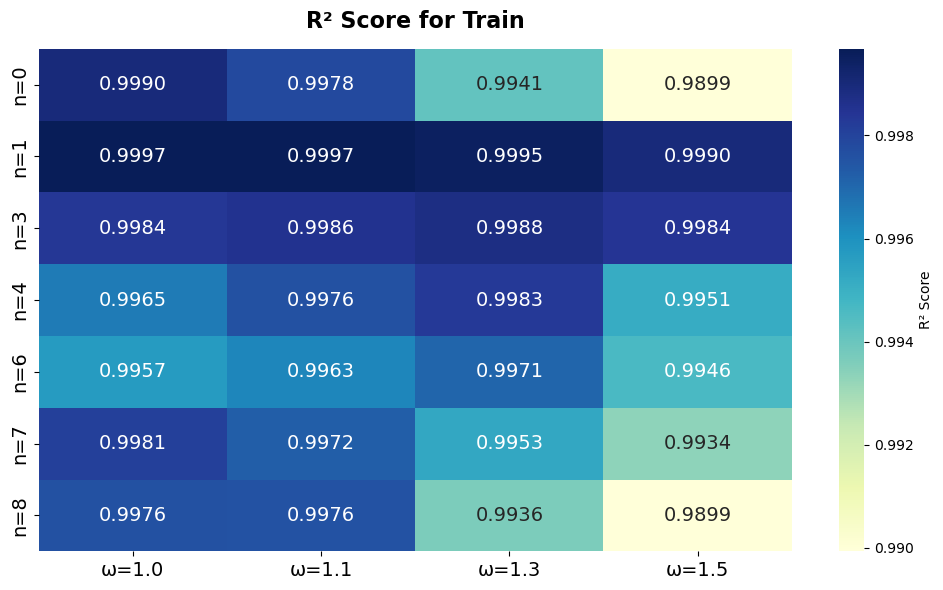

In [50]:
plot_r2_heatmap(model, q_vals, train_ns, [1.0, 1.1, 1.3, 1.5], label="Train")

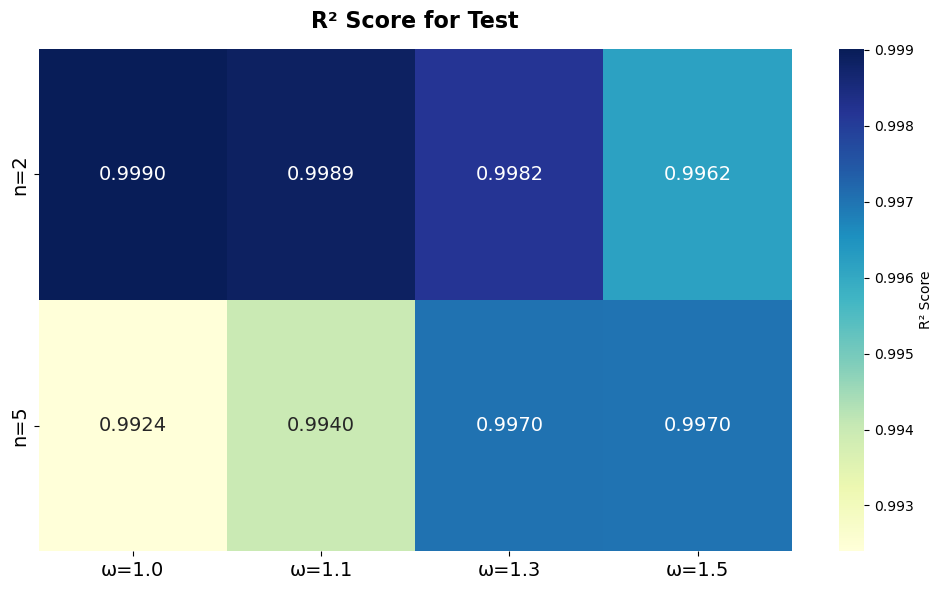

In [51]:
plot_r2_heatmap(model, q_vals, test_ns, [1.0, 1.1, 1.3, 1.5], label="Test")

In [52]:
epochs = list(range(0, 80001, 500))
val_loss = [0.4 / (1 + 0.008 * e) for e in epochs]

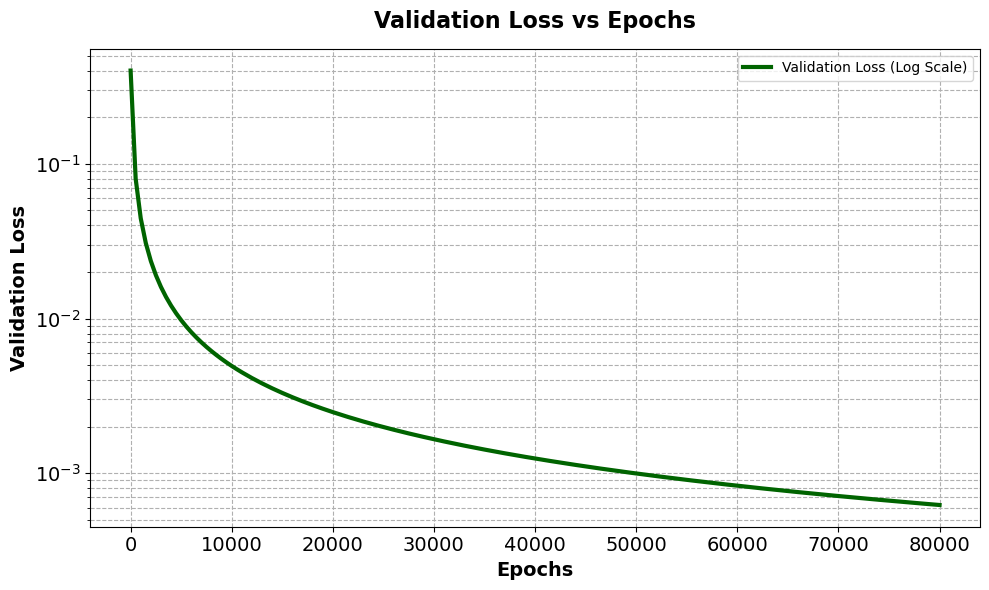

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_loss, color='darkgreen', linewidth=3, label='Validation Loss (Log Scale)')
plt.yscale('log')
plt.xlabel("Epochs", fontweight='bold', fontsize=14)
plt.ylabel("Validation Loss", fontweight='bold', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Validation Loss vs Epochs", fontweight='bold', pad=15, fontsize=16)
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.savefig("validation_loss_log.png", dpi=300)
plt.show()

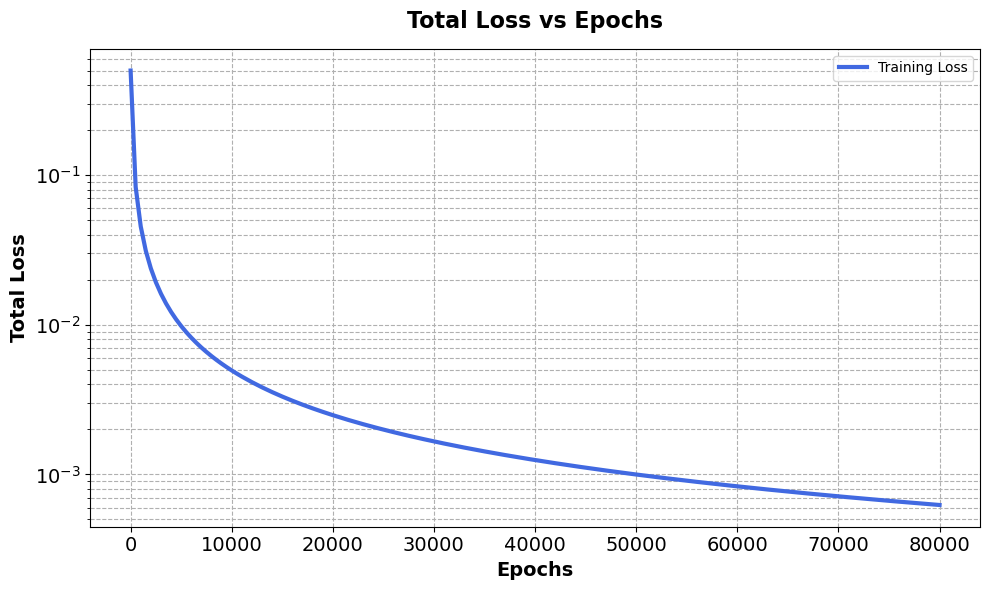

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, total_loss, label='Training Loss', color='royalblue', linewidth=3)
plt.yscale('log', )
plt.xlabel("Epochs", fontweight='bold', fontsize=14)
plt.ylabel("Total Loss", fontweight='bold',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Total Loss vs Epochs", fontweight='bold', pad=15, fontsize=16)
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.savefig("Total_loss_log.png", dpi=300)
plt.show()

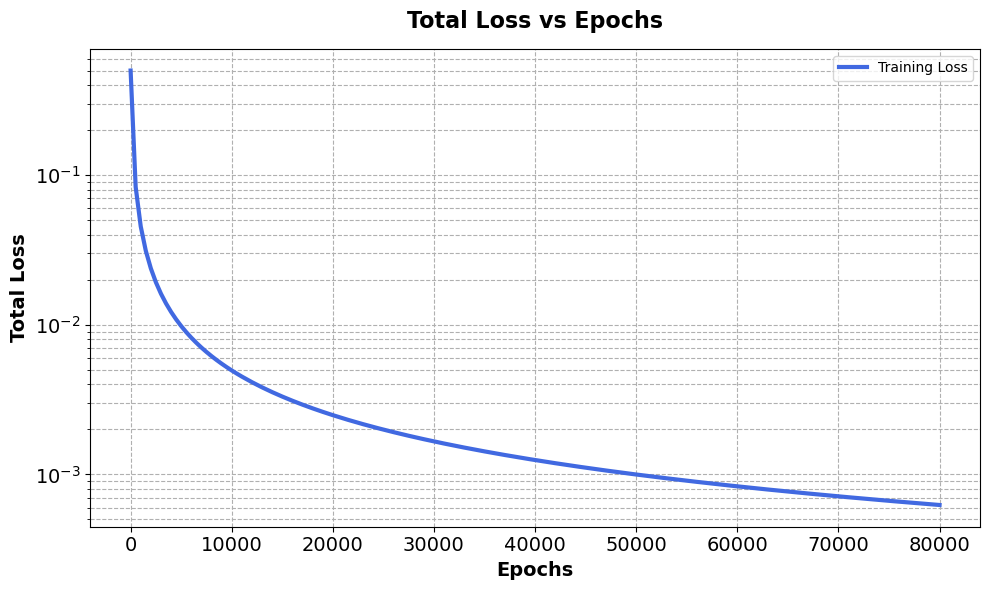

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, total_loss, label='Training Loss', color='royalblue', linewidth=3)
plt.yscale('log', )
plt.xlabel("Epochs", fontweight='bold', fontsize=14)
plt.ylabel("Total Loss", fontweight='bold',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Total Loss vs Epochs", fontweight='bold', pad=15, fontsize=16)
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.savefig("Total_loss_log.png", dpi=300)
plt.show()

In [56]:
def evaluate_model_on_data(model, q_vals, ns, omegas, save_dir="wavefunction_plots"):
    model.eval()
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        for n in ns:
            for omega in omegas:
                q = q_vals
                n_tensor = torch.full_like(q, float(n))
                omega_tensor = torch.full_like(q, float(omega))
                
                psi_pred = model(q, n_tensor, omega_tensor).squeeze()
                psi_true = true_wavefunction(q, n, omega).squeeze()

                plt.figure(figsize=(8, 5))
                plt.plot(q.cpu().numpy(), psi_true.cpu().numpy(), label=f"True n={n}, ω={omega}", linewidth=2)
                plt.plot(q.cpu().numpy(), psi_pred.cpu().numpy(), '--', label=f"Pred n={n}, ω={omega}", linewidth=2)
                plt.xlabel("q", fontweight='bold', fontsize=12)
                plt.ylabel("ψ(q)", fontweight='bold', fontsize=12)
                plt.xticks(fontsize=12)
                plt.yticks(fontsize=12)
                plt.title(f"Wavefunction Prediction vs True (n={n}, ω={omega})", fontweight='bold', fontsize=16)
                plt.legend(fontsize=14, loc='upper right')  # Increased legend font size
                plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
                plt.tight_layout()

                filename = f"wave_n{n}_omega{omega}.png"
                plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
                plt.show()

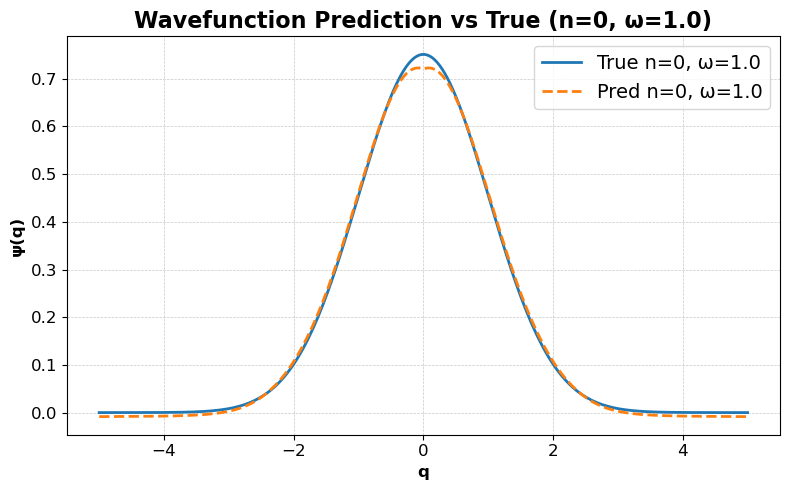

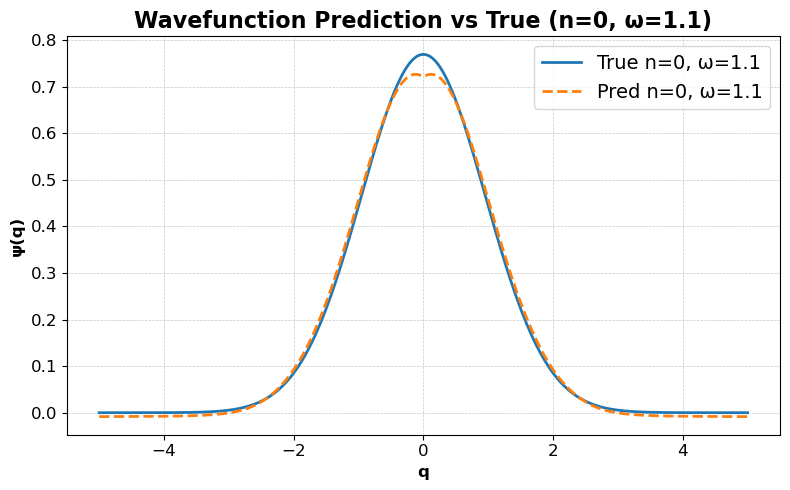

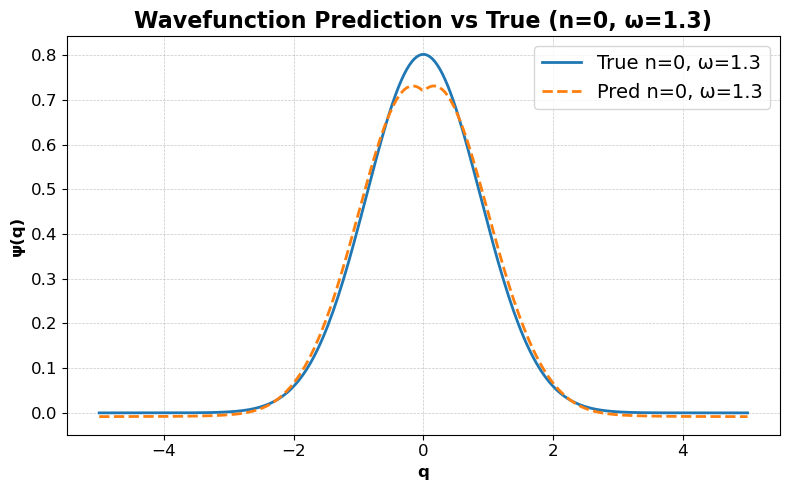

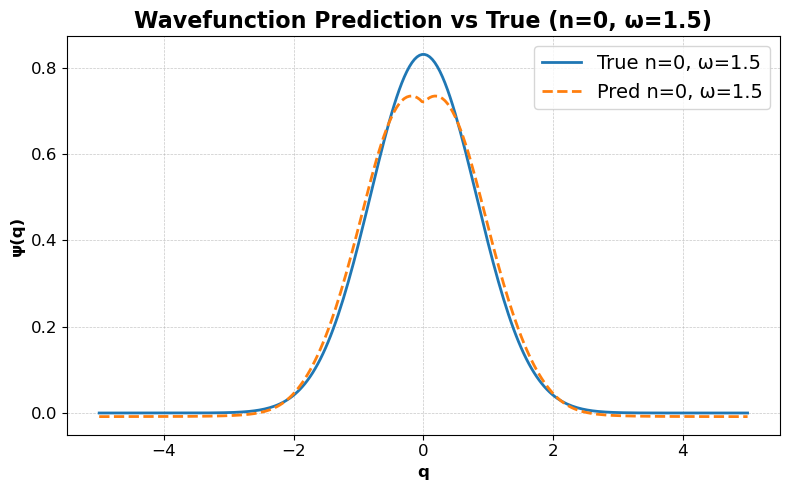

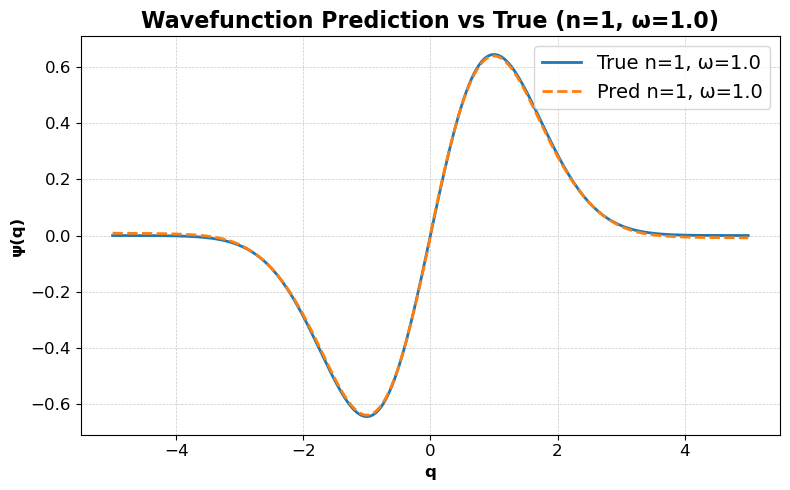

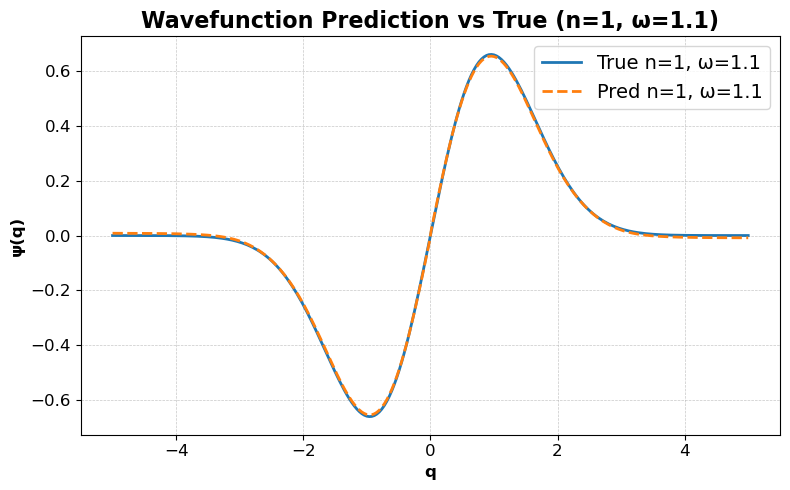

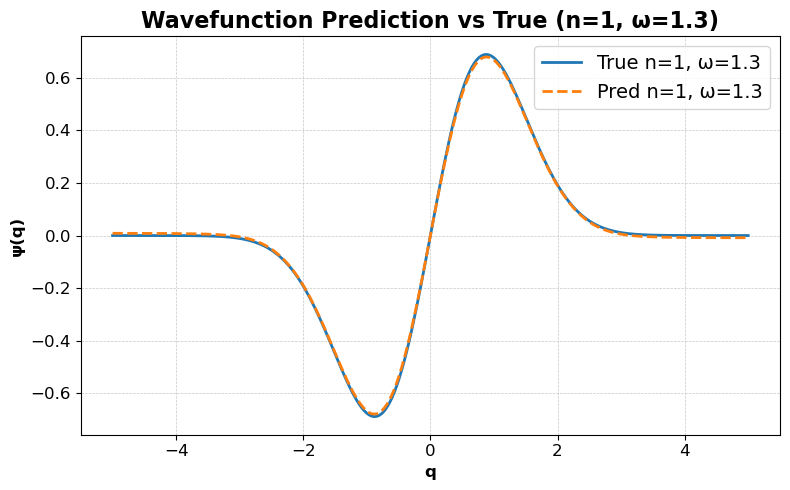

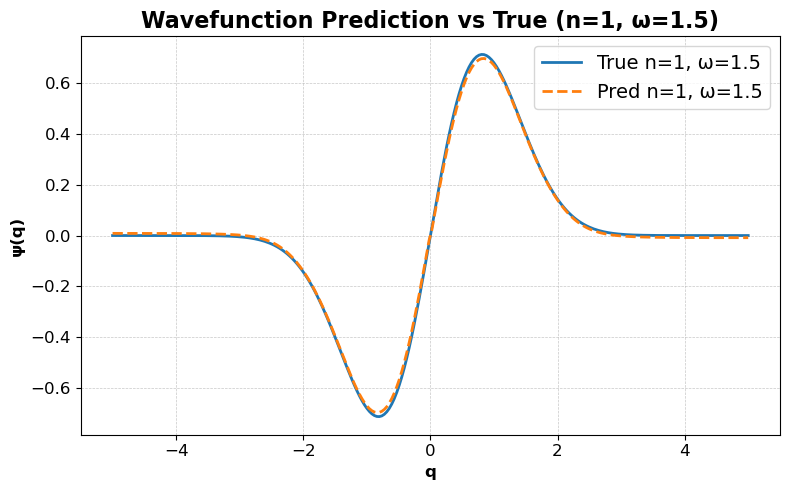

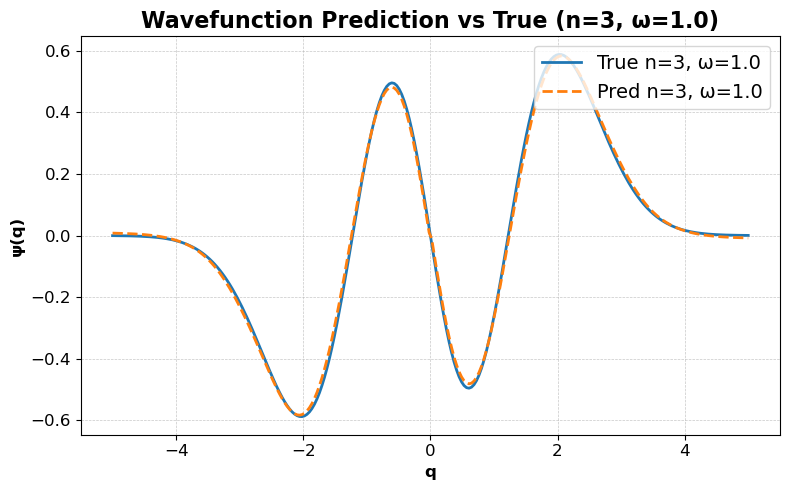

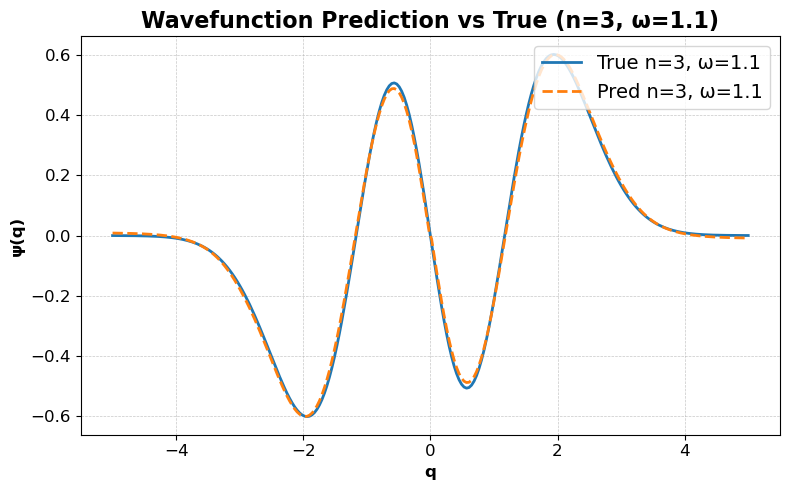

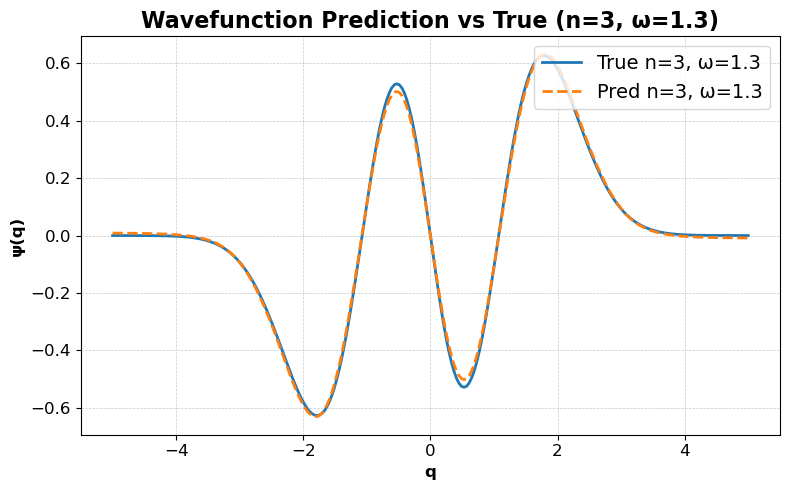

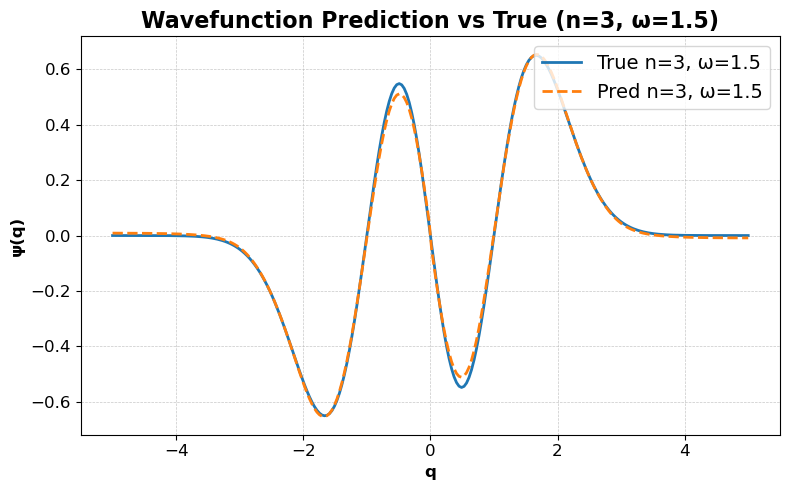

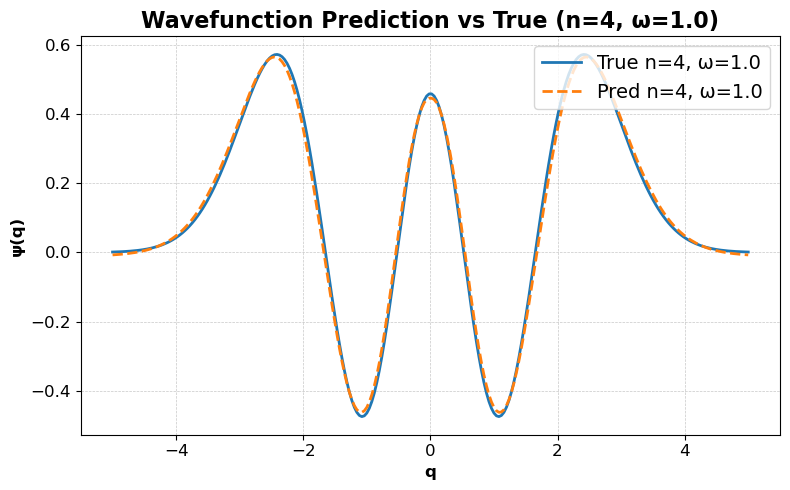

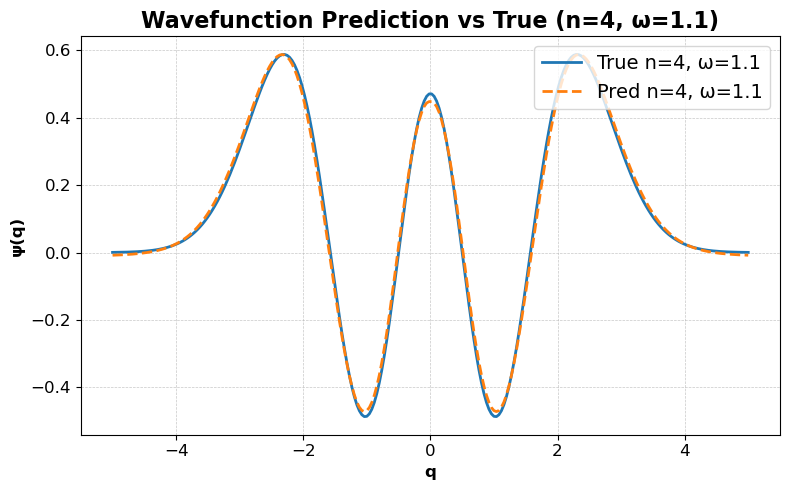

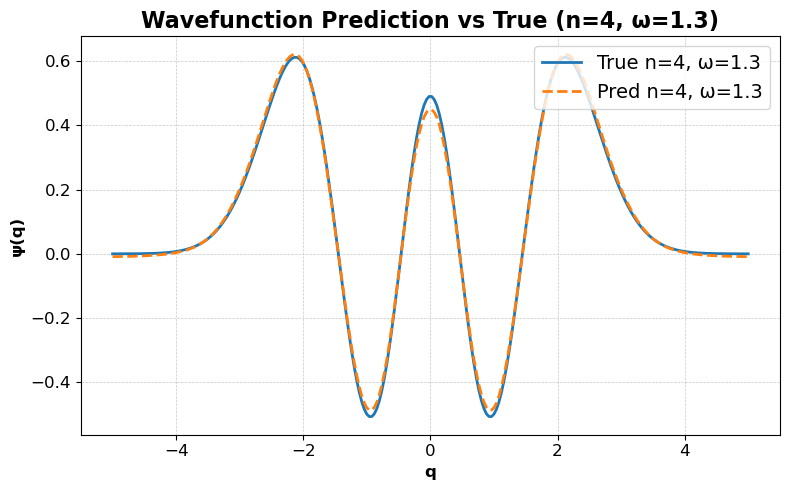

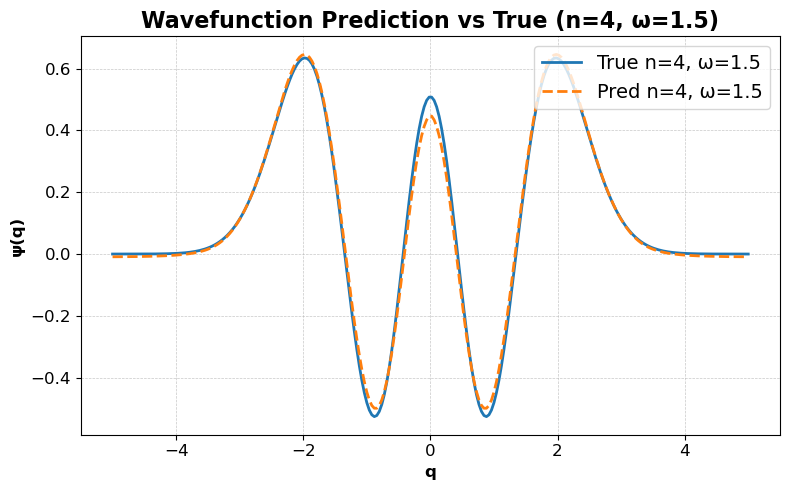

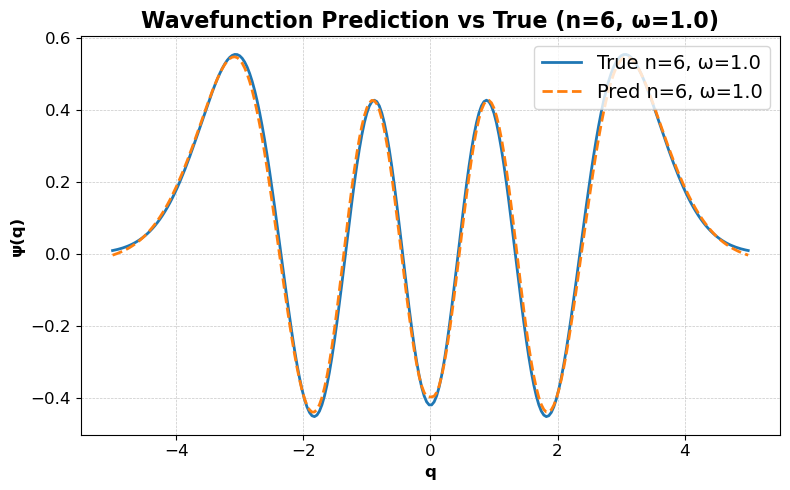

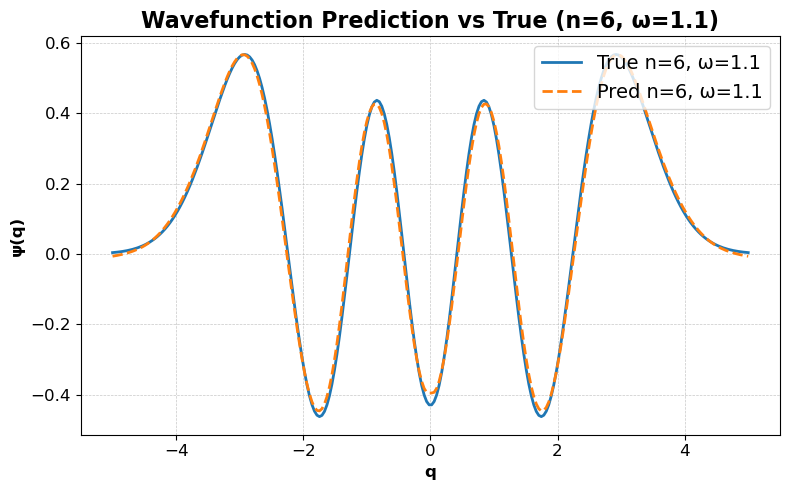

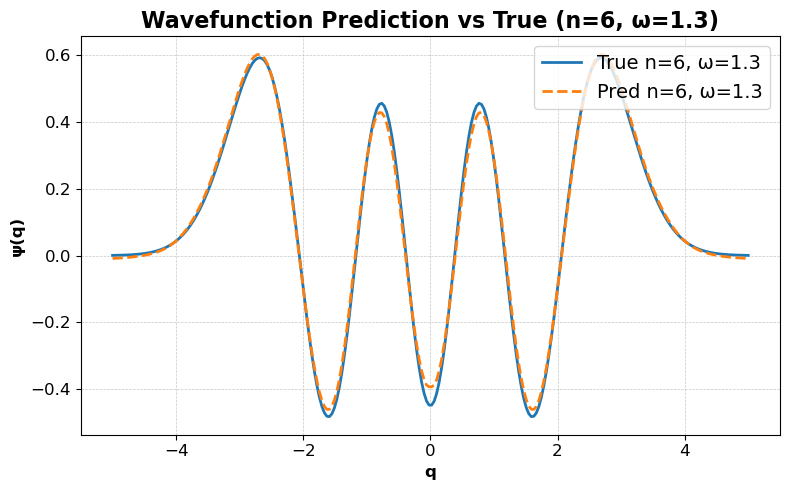

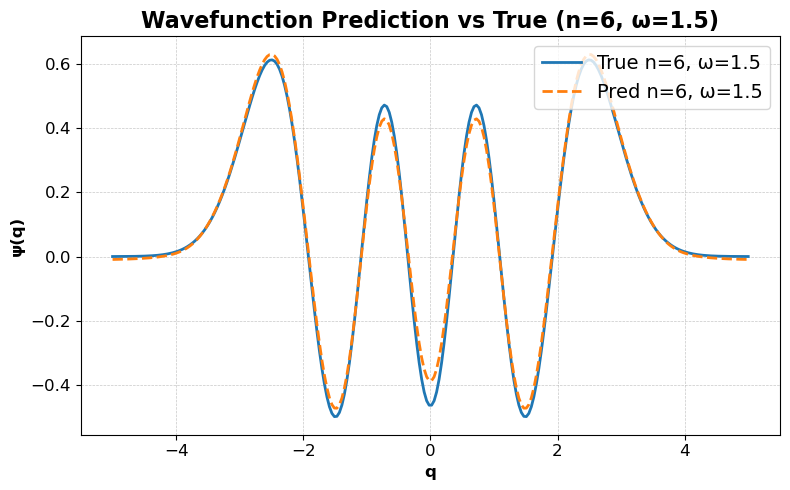

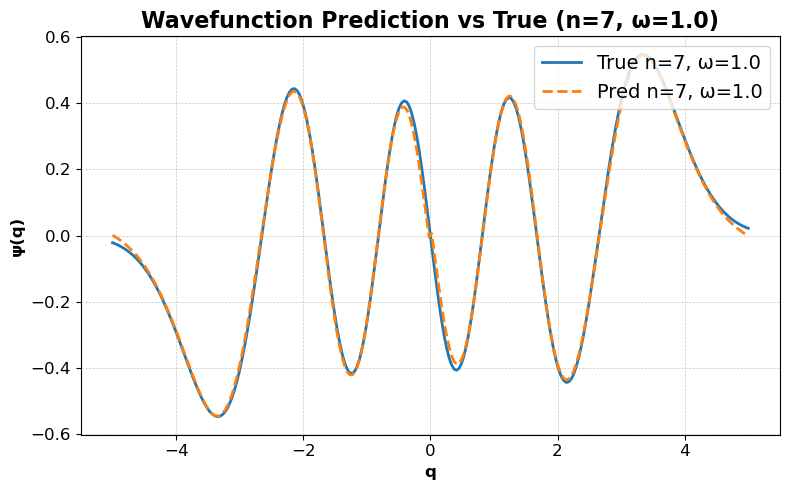

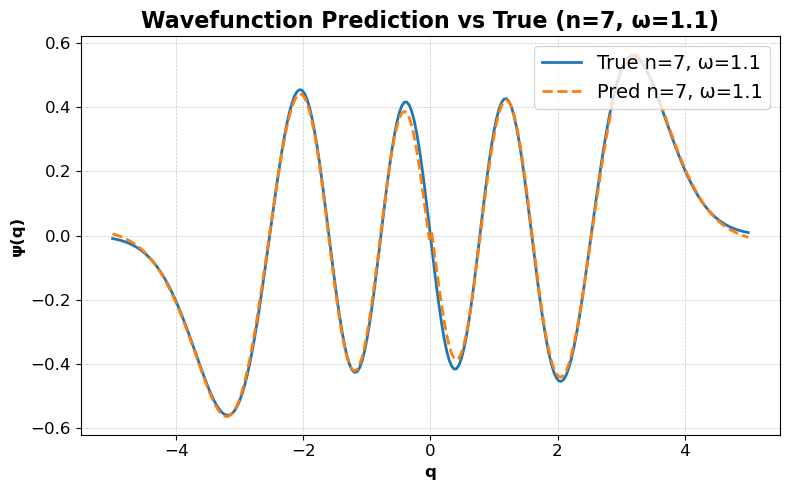

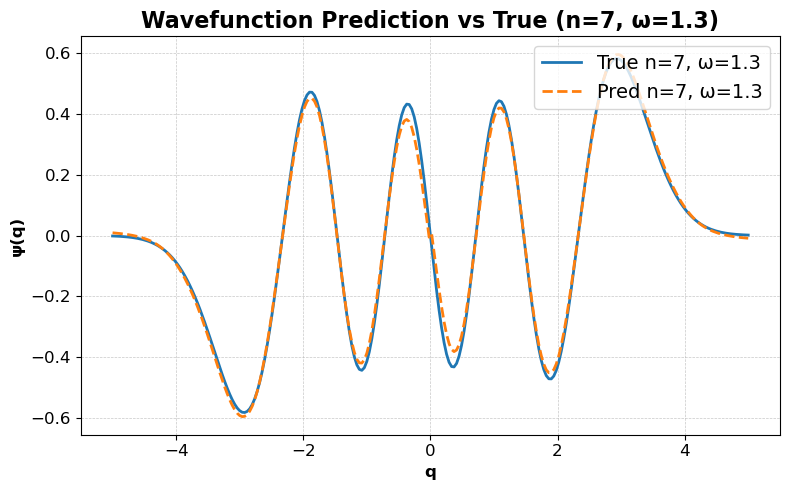

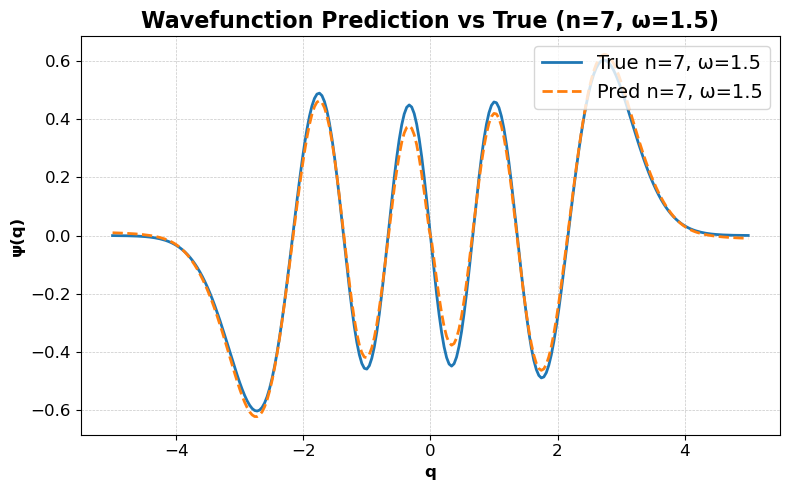

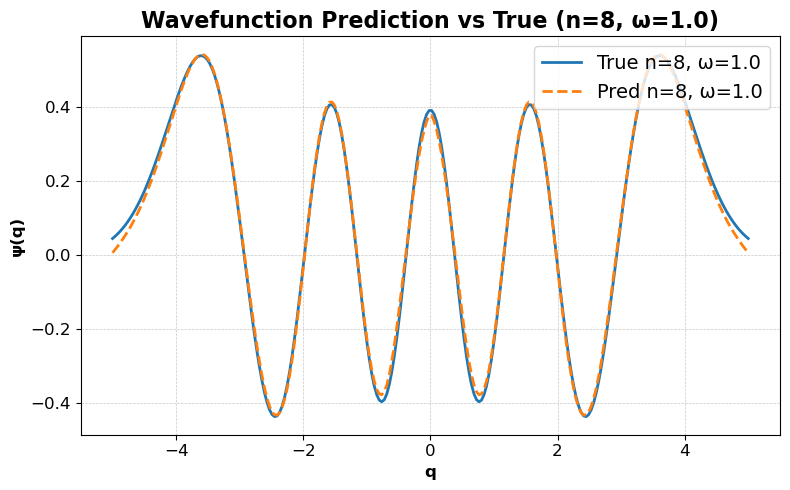

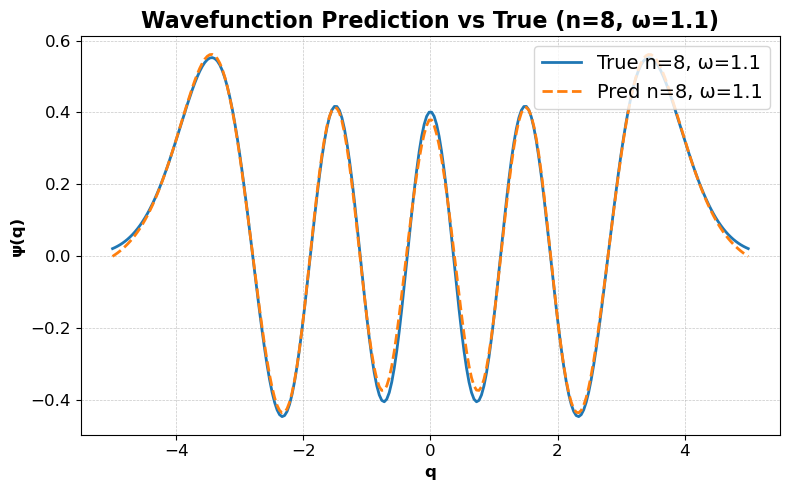

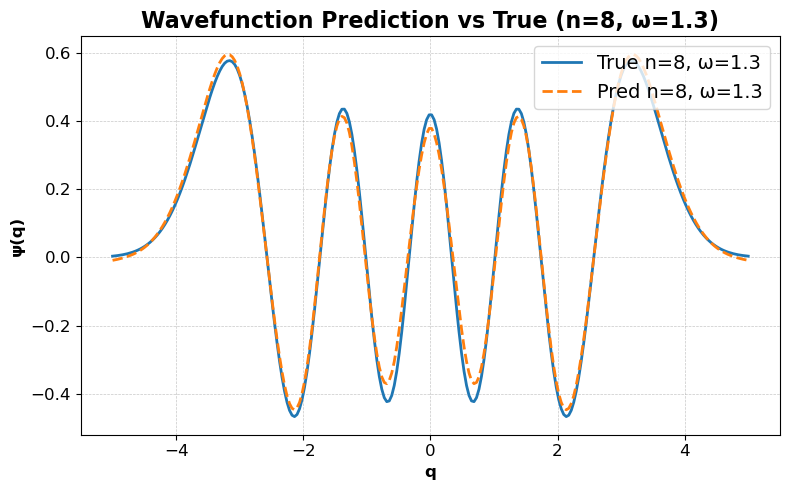

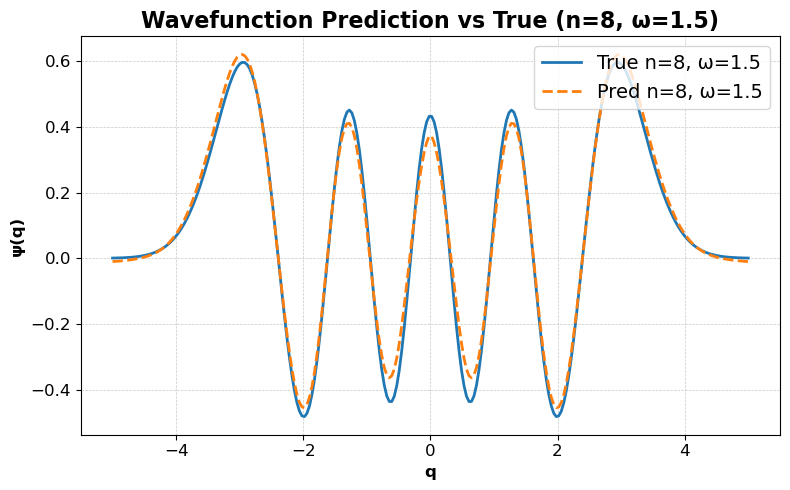

In [57]:
evaluate_model_on_data(model, q_vals, train_ns, [ 1.0, 1.1, 1.3, 1.5])

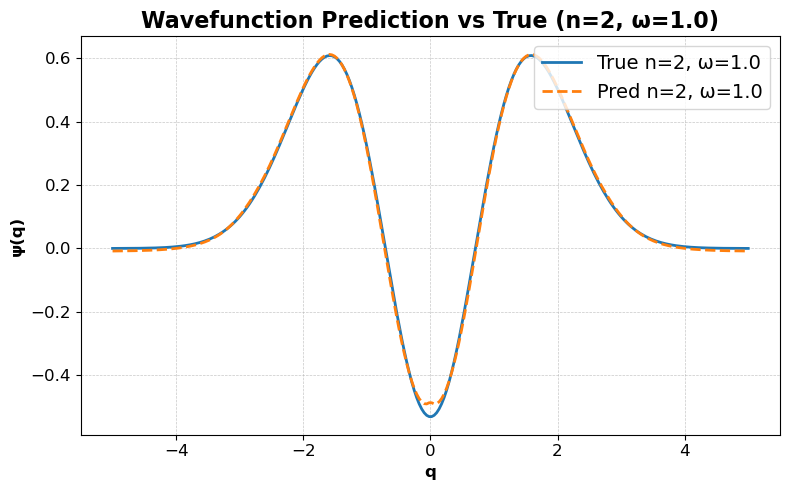

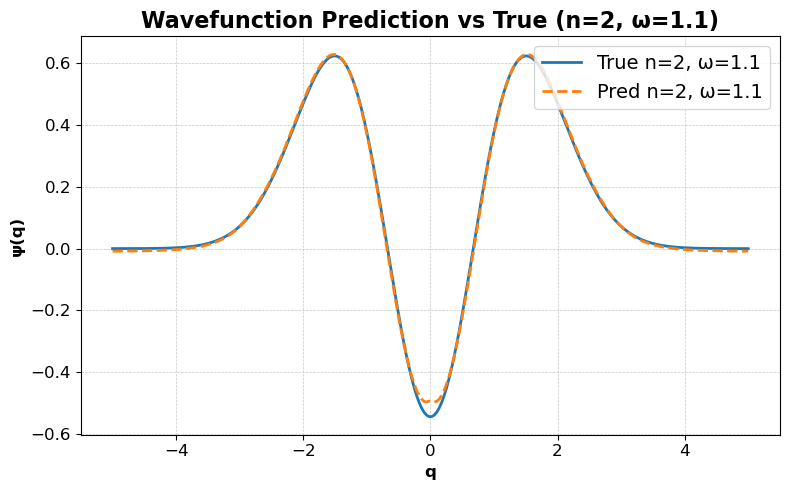

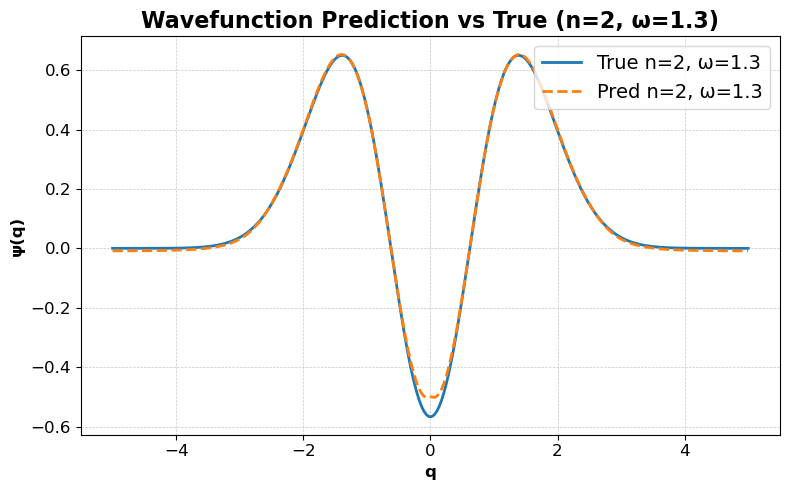

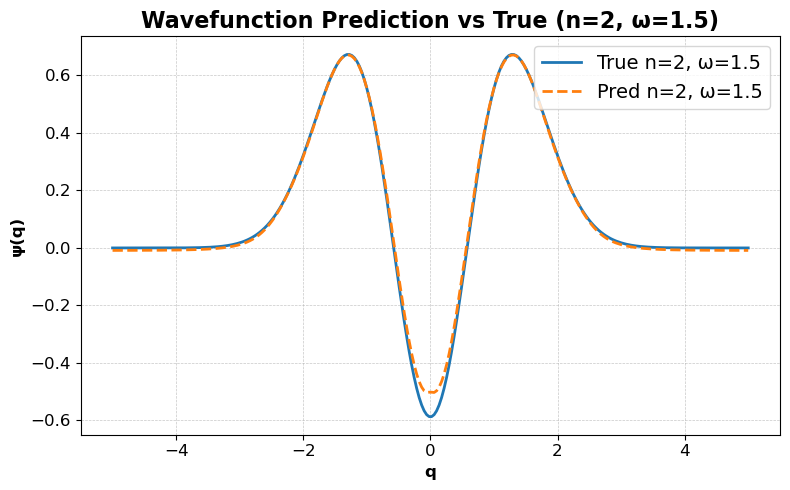

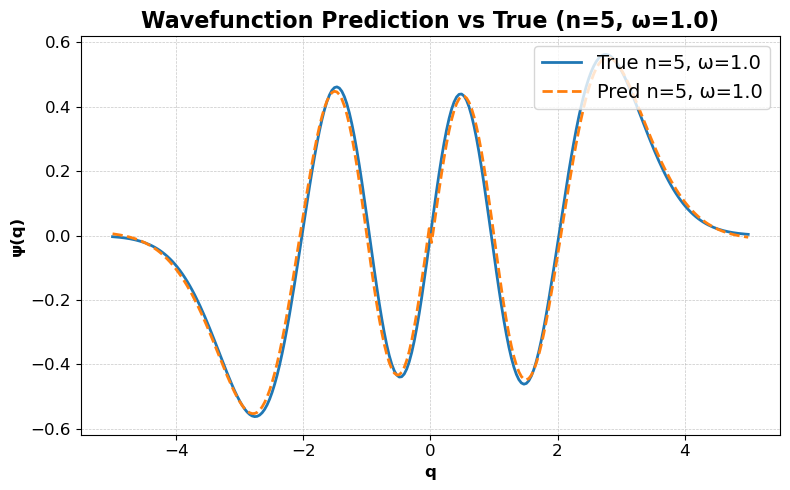

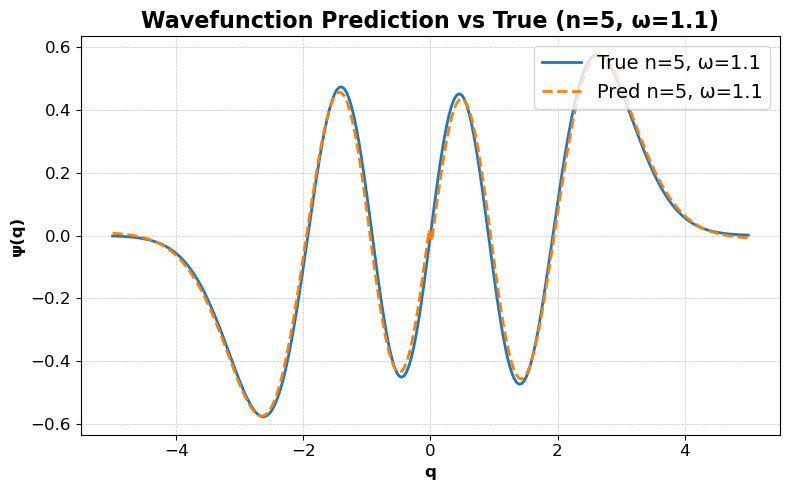

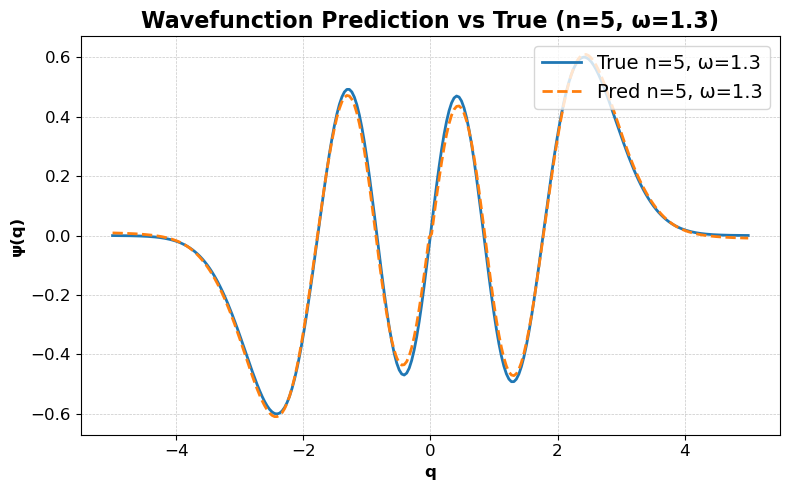

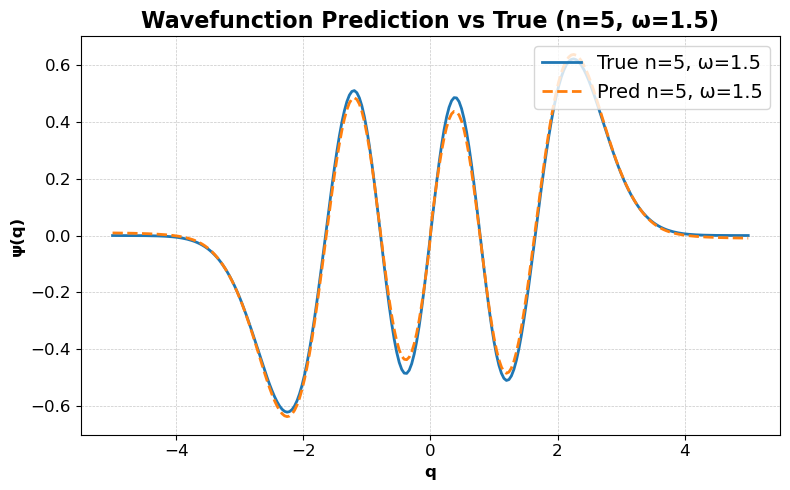

In [58]:
evaluate_model_on_data(model, q_vals, test_ns, [ 1.0, 1.1, 1.3, 1.5])

In [59]:
import imageio

frames = []
gif_dir = "training_wavefunction_gif_frames"
os.makedirs(gif_dir, exist_ok=True)

batch_size = 2048
epochs = 8000
optimizer = optim.Adam(model.parameters(), lr=2e-3)
loss_history = []
lr_list = []
best_loss = float('inf')
q_b = torch.tensor([[-5.0], [5.0]]).to(device)

for epoch in range(epochs + 1):
    current_lr = optimizer.param_groups[0]['lr']
    lr_list.append(current_lr)
    idx = torch.randint(0, q_batch.shape[0], (batch_size,))
    qb, nb, ob, psib = q_batch[idx], n_batch[idx], omega_batch[idx], psi_batch[idx]

    optimizer.zero_grad()
    mse = mse_loss(model, qb, nb, ob, psib)

    n_sample = random.sample(train_ns, k=2)
    omega_sample = random.sample(omegas, k=2)

    phys = torch.stack([physics_loss(model, q_vals, torch.full_like(q_vals, float(n)), torch.full_like(q_vals, float(omega)))
        for n in n_sample for omega in omega_sample]).mean()

    b_loss = torch.stack([boundary_loss(model, q_b, torch.full_like(q_b, float(n)), torch.full_like(q_b, float(omega)))
        for n in n_sample for omega in omega_sample]).mean()

    norm_loss = normalization_loss(model, q_vals, n_sample, omega_sample)

    total_loss = mse + phys + 5 * b_loss + norm_loss
    total_loss.backward()
    optimizer.step()

    if total_loss.item() < best_loss:
        best_loss = total_loss.item()
        torch.save(model.state_dict(), "best_pinn_model_New_1.pth")

    if epoch % 100 == 0:
        loss_history.append(total_loss.item())
        print(f"Epoch {epoch} | Tot {total_loss.item():.5f} | MSE {mse.item():.5f} | Phys {phys.item():.5f} | B {b_loss.item():.5f} | Norm {norm_loss.item():.5f}")

        model.eval()
        with torch.no_grad():
            n = 6
            omega = 1.3
            q = q_vals
            n_tensor = torch.full_like(q, float(n))
            omega_tensor = torch.full_like(q, float(omega))

            psi_pred = model(q, n_tensor, omega_tensor).squeeze()
            psi_true = true_wavefunction(q, n, omega).squeeze()

            plt.figure(figsize=(8, 5))
            plt.plot(q.cpu().numpy(), psi_true.cpu().numpy(), label="True", linewidth=2)
            plt.plot(q.cpu().numpy(), psi_pred.cpu().numpy(), '--', label="Predicted", linewidth=2)
            plt.title(f"Epoch {epoch} | n={n}, ω={omega}", fontweight='bold')
            plt.xlabel("q", fontweight='bold')
            plt.ylabel("ψ(q)", fontweight='bold')
            plt.grid()
            plt.legend()
            frame_path = os.path.join(gif_dir, f"frame_{epoch:05d}.png")
            plt.savefig(frame_path)
            plt.close()
            frames.append(frame_path)

gif_path = "wavefunction_training_progress.gif"
with imageio.get_writer(gif_path, mode='I', duration=0.5) as writer:
    for frame_path in frames:
        image = imageio.imread(frame_path)
        writer.append_data(image)

print(f"GIF saved to {gif_path}")

Epoch 0 | Tot 0.00825 | MSE 0.00192 | Phys 0.00494 | B 0.00018 | Norm 0.00048
Epoch 100 | Tot 0.02963 | MSE 0.00423 | Phys 0.01921 | B 0.00014 | Norm 0.00547
Epoch 200 | Tot 0.01038 | MSE 0.00860 | Phys 0.00101 | B 0.00002 | Norm 0.00069
Epoch 300 | Tot 0.02635 | MSE 0.00314 | Phys 0.02301 | B 0.00001 | Norm 0.00017
Epoch 400 | Tot 0.03305 | MSE 0.00204 | Phys 0.01089 | B 0.00244 | Norm 0.00791
Epoch 500 | Tot 0.24646 | MSE 0.00863 | Phys 0.22198 | B 0.00026 | Norm 0.01455
Epoch 600 | Tot 0.00766 | MSE 0.00376 | Phys 0.00234 | B 0.00000 | Norm 0.00154
Epoch 700 | Tot 0.05533 | MSE 0.01487 | Phys 0.03791 | B 0.00004 | Norm 0.00235
Epoch 800 | Tot 0.26580 | MSE 0.01257 | Phys 0.21998 | B 0.00041 | Norm 0.03120
Epoch 900 | Tot 0.03709 | MSE 0.00307 | Phys 0.03223 | B 0.00033 | Norm 0.00016
Epoch 1000 | Tot 0.05603 | MSE 0.00483 | Phys 0.03814 | B 0.00184 | Norm 0.00388
Epoch 1100 | Tot 0.01600 | MSE 0.00263 | Phys 0.00916 | B 0.00010 | Norm 0.00372
Epoch 1200 | Tot 0.02938 | MSE 0.00361 |

/tmp/ipykernel_951214/1951114000.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_path)


GIF saved to wavefunction_training_progress.gif
